In [64]:
import hdbscan, os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import umap.umap_ as umap
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans, SpectralClustering
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.metrics import adjusted_rand_score

In [2]:
def prepare_data (location: str) -> tuple:
    """Return pandas dataframe with proper labeled columns and adjusted
    values.

    Args:
        location (str): The location directory in string form.

    Returns:
        pd.DataFrame: data file -> pandas dataframe
    """
    cols = ['chr_i', 'pos_i', 'chr_j', 'pos_j', 'contacts']
    
    df = pd.read_csv(location, names=cols, sep=r'\s+')
    df['pos_i'] = df['pos_i'] // 1000000
    df['pos_j'] = df['pos_j'] // 1000000
    return df

In [177]:
def find_chr_length (data: pd.DataFrame) -> dict[str: tuple]:
    """Return a dictionary containing each unique chromosome mapped to their lengths
    as a tuple (min_length, max_length).
    
    Args:
        data (pd.DataFrame): DataFrame with ['chr_i', 'pos_i', 'chr_j', 'pos_j', 'contacts']

    Returns:
        dict: chromosome -> length (min, max)
    """
    chr_bounds = {}
    chromosomes = sorted(set(data['chr_i']).union(data['chr_j']), key=lambda x: int(x[3:]) if x[3:].isdigit() else 100)
    for chr_ in chromosomes:
            max_i = data.loc[data['chr_i'] == chr_, 'pos_i'].max()
            max_j = data.loc[data['chr_j'] == chr_, 'pos_j'].max()
            min_i = data.loc[data['chr_i'] == chr_, 'pos_i'].min()
            min_j = data.loc[data['chr_j'] == chr_, 'pos_j'].min()
            chr_bounds[chr_] = (min(min_i, min_j), max(max_i, max_j))
    return chr_bounds

In [4]:
def build_chr_block_matrix(data: pd.DataFrame) -> pd.DataFrame:
    """Return a DataFrame where rows and columns are chromosomes and
    each cell contains a symmetric contact matrix (DataFrame) between those chromosomes.

    Args:
        data (pd.DataFrame): DataFrame with ['chr_i', 'pos_i', 'chr_j', 'pos_j', 'contacts']

    Returns:
        pd.DataFrame: block DataFrame of contact matrices
    """
    # compute length of chromosome
    chr_bounds = find_chr_length(data)
    chromosomes = sorted(set(data['chr_i']).union(data['chr_j']), key=lambda x: int(x[3:]) if x[3:].isdigit() else 100)

    # initialize zero block matrix as pandas dataframe
    chr_block_df = pd.DataFrame(0, index=chromosomes, columns=chromosomes, dtype=object)

    # fill diagonal with contact matrices between chromosomes
    for chr_i in chromosomes:
        for chr_j in chromosomes:
            # set lengths for chromosome contact matrix
            min_i, max_i = chr_bounds[chr_i]
            min_j, max_j = chr_bounds[chr_j]
            row_bins = list(range(min_i, max_i + 1))
            col_bins = list(range(min_j, max_j + 1))

            # find the diagonal point
            if chr_i == chr_j:
                # initialize zero matrix of size chromosome
                mat = pd.DataFrame(0, index=row_bins, columns=col_bins)
                # find subset of actual contact data for this chr pair
                subdf = data[(data['chr_i'] == chr_i) & (data['chr_j'] == chr_j)]
                for _, row in subdf.iterrows():
                    i, j, c = row['pos_i'], row['pos_j'], row['contacts']
                    mat.iat[i - min_i, j - min_j] = c
                # set diagonal block as that contact matrix
                chr_block_df.at[chr_i, chr_j] = mat
    return chr_block_df

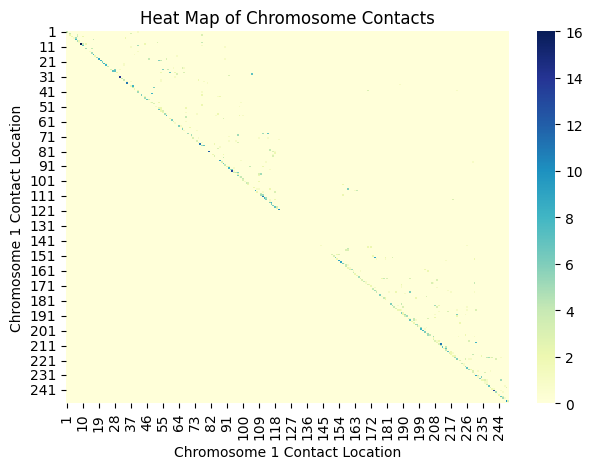

In [178]:
df = prepare_data('/Users/salah/Documents/hic-cell-classification/data/HAP1/ml1_AAGCCGGT-ATACATGT.txt')
matrix = build_chr_block_matrix(df)

sns.heatmap(matrix.at['chr1', 'chr1'], cmap='YlGnBu')
plt.title("Heat Map of Chromosome Contacts")
plt.xlabel("Chromosome 1 Contact Location")
plt.ylabel("Chromosome 1 Contact Location")
plt.tight_layout()
plt.show()

In [6]:
def cell_summary_stats(matrix: pd.DataFrame) -> dict:
    """
    Return summary statistics of the cell based on intra-chromosomal contact matrices
    (i.e., the diagonal blocks only).

    Args:
        matrix (pd.DataFrame): block matrix where only diagonal cells contain data

    Returns:
        dict: {
            'total_contacts': float,
            'mean_contact': float,
            'var_contact': float
        }
    """
    all_contacts = []

    for chr in matrix.index:
        block = matrix.at[chr, chr]
        # convert block as numpy array and then flaten into 1D array and append
        all_contacts.append(block.values.ravel())

    # transform all 1D arrays into one 1D array
    flat_contacts = np.concatenate(all_contacts)

    num_zero = np.sum(flat_contacts == 0)
    num_nonzero = np.sum(flat_contacts > 0)

    return {
        'total_contacts': float(np.sum(flat_contacts)),
        'mean_contact': float(np.mean(flat_contacts)),
        'var_contact': float(np.var(flat_contacts)),
        'num_zero_contacts': int(num_zero),
        'num_nonzero_contacts': int(num_nonzero)
    }

In [7]:
def per_chr_summary_stats(df: pd.DataFrame, matrix: pd.DataFrame) -> dict:
    """
    For each chromosome's intra-chromosomal contact matrix (on the diagonal),
    return summary stats including:
      - Total, mean, variance of contact intensity
      - Total, mean, variance of diagonal-only entries
      - Mean and variance of distance-from-diagonal (|i - j|) for non-zero contacts

    Args:
        df (pd.DataFrame): not used
        matrix (pd.DataFrame): 23x23 block matrix with only diagonal blocks populated

    Returns:
        dict: {
            'chrX': {
                'total': float,
                'mean': float,
                'var': float,
                'diag_total': float,
                'diag_mean': float,
                'diag_var': float,
                'contact_dist_mean': float,
                'contact_dist_var': float
            },
            ...
        }
    """
    stats = {}

    for chr in matrix.index:
        block = matrix.at[chr, chr]

        # convert blocks and giagonal into numpy arrays
        values = block.values
        diag_values = np.diag(values)

        # Get distance-from-diagonal (abs(i - j)) for non-zero contacts
        contact_dists = []
        # get the row dimension of array
        n = values.shape[0]

        # iterate through numpy array
        for i in range(n):
            for j in range(n):
                contact = values[i, j]
                if contact > 0:
                    dist = abs(i - j)
                    contact_dists.append(dist)

        # convert list into numpy array
        contact_dists = np.array(contact_dists)

        stats[chr] = {
            'total': float(np.sum(values)),
            'mean': float(np.mean(values)),
            'var': float(np.var(values)),

            'diag_total': float(np.sum(diag_values)),
            'diag_mean': float(np.mean(diag_values)),
            'diag_var': float(np.var(diag_values)),

            'contact_dist_mean': float(np.mean(contact_dists)) if len(contact_dists) > 0 else 0.0,
            'contact_dist_var': float(np.var(contact_dists)) if len(contact_dists) > 0 else 0.0
        }

    return stats

In [8]:
def read_all_in_cell_type(folder_path: str, cell_type: str, file_suffix: str = ".txt") -> pd.DataFrame:
    """
    Loop through all cell files in a folder and extract cell-level and
    per-chromosome contact statistics.

    Args:
        folder_path (str): Path to directory with cell contact files.
        file_suffix (str): File extension to filter on (default = ".txt").

    Returns:
        pd.DataFrame: One row per cell, with summary statistics as columns.
    """
    cells = []

    for fname in os.listdir(folder_path):
        cell_id = os.path.splitext(fname)[0]
        cell_path = os.path.join(folder_path, fname)

        try:
            # Load and process each cell data
            df = prepare_data(location=cell_path)
                
            matrix = build_chr_block_matrix(df)

            features = {'cell_id': cell_id, 'cell_type': cell_type}

            # add summary stats for whole cell as features
            features.update(cell_summary_stats(matrix))

            # add summary stats by chromosome for each cell
            per_chr_stats = per_chr_summary_stats(df, matrix)
            for chr_name, chr_stat_dict in per_chr_stats.items():
                for stat_name, value in chr_stat_dict.items():
                    features[f"{chr_name}_{stat_name}"] = value

            # add features for this cells as a dictionary
            cells.append(features)

        except Exception as error:
            print(f"Error processing {fname}: {error}")

    return pd.DataFrame(cells).set_index('cell_id')

gm_12878 = read_all_in_cell_type(folder_path='/Users/salah/Documents/hic-cell-classification/data/GM12878', cell_type='GM12878')
hap_1 = read_all_in_cell_type(folder_path='/Users/salah/Documents/hic-cell-classification/data/HAP1', cell_type='HAP1')
hela = read_all_in_cell_type(folder_path='/Users/salah/Documents/hic-cell-classification/data/Hela', cell_type='Hela')
k_562 = read_all_in_cell_type(folder_path='/Users/salah/Documents/hic-cell-classification/data/K562', cell_type='K562')

In [147]:
def keep_top_75_percent(group):
    threshold = group["num_zero_contacts"].quantile(0.75)
    return group[group["num_zero_contacts"] <= threshold]

def filter_by_percent(df, percent):
    n = int(len(df) * percent)
    return df.nsmallest(n, "num_zero_contacts")

In [322]:
master_df = pd.concat([gm_12878, hap_1, hela, k_562], ignore_index=True)

# filter cells by lowest zero contact
hela_filtered = filter_by_percent(master_df[master_df["cell_type"] == "Hela"], 1)
hap1_filtered = filter_by_percent(master_df[master_df["cell_type"] == "HAP1"], 1)
other_filtered = master_df[master_df["cell_type"].isin(["K562", "GM12878"])]

filtered_df = pd.concat([hela_filtered, hap1_filtered, other_filtered], ignore_index=True)

# drop chromosomes
drop_chroms = ["chr2_", "chr3", "chr4", "chr6", "chr9", "chr13", "chr14", "chrX"]
drop_prefixes = [chrom if chrom.endswith("_") else f"{chrom}_" for chrom in drop_chroms]

cols_to_drop = [col for col in filtered_df.columns if any(col.startswith(prefix) for prefix in drop_prefixes)]

test_df = filtered_df.drop(columns=cols_to_drop)
test_df.head()

,cell_type,total_contacts,mean_contact,var_contact,num_zero_contacts,num_nonzero_contacts,chr1_total,chr1_mean,chr1_var,chr1_diag_total,...,chr21_contact_dist_mean,chr21_contact_dist_var,chr22_total,chr22_mean,chr22_var,chr22_diag_total,chr22_diag_mean,chr22_diag_var,chr22_contact_dist_mean,chr22_contact_dist_var
0,Hela,208632.0,0.452148,10.416726,423821,37603,19493.0,0.311888,7.928470,8931.0,...,6.876325,46.991772,1296.0,1.057959,18.361539,800.0,22.857143,55.493878,5.569061,42.709319
1,Hela,264593.0,0.574197,24.185272,432435,28370,25759.0,0.412144,19.191657,14942.0,...,5.981132,45.414738,1765.0,1.440816,45.031803,1263.0,36.085714,191.906939,4.688406,40.460880
2,Hela,215726.0,0.467911,15.053237,435061,25980,17569.0,0.281104,9.361061,9823.0,...,5.740933,42.451019,2008.0,1.639184,46.908179,1277.0,36.485714,216.364082,6.260664,50.334898
3,Hela,89783.0,0.194880,2.095418,435712,24996,8643.0,0.138288,1.619260,4024.0,...,5.417112,44.949012,635.0,0.518367,4.618642,400.0,11.428571,19.502041,5.795918,62.516174
4,Hela,99288.0,0.215502,2.750137,435764,24964,9608.0,0.153728,2.260432,4783.0,...,5.680000,48.789029,503.0,0.410612,3.507316,351.0,10.028571,16.256327,4.932773,55.474472


cell_type
Hela       1622
HAP1        917
K562         48
GM12878      24
Name: count, dtype: int64


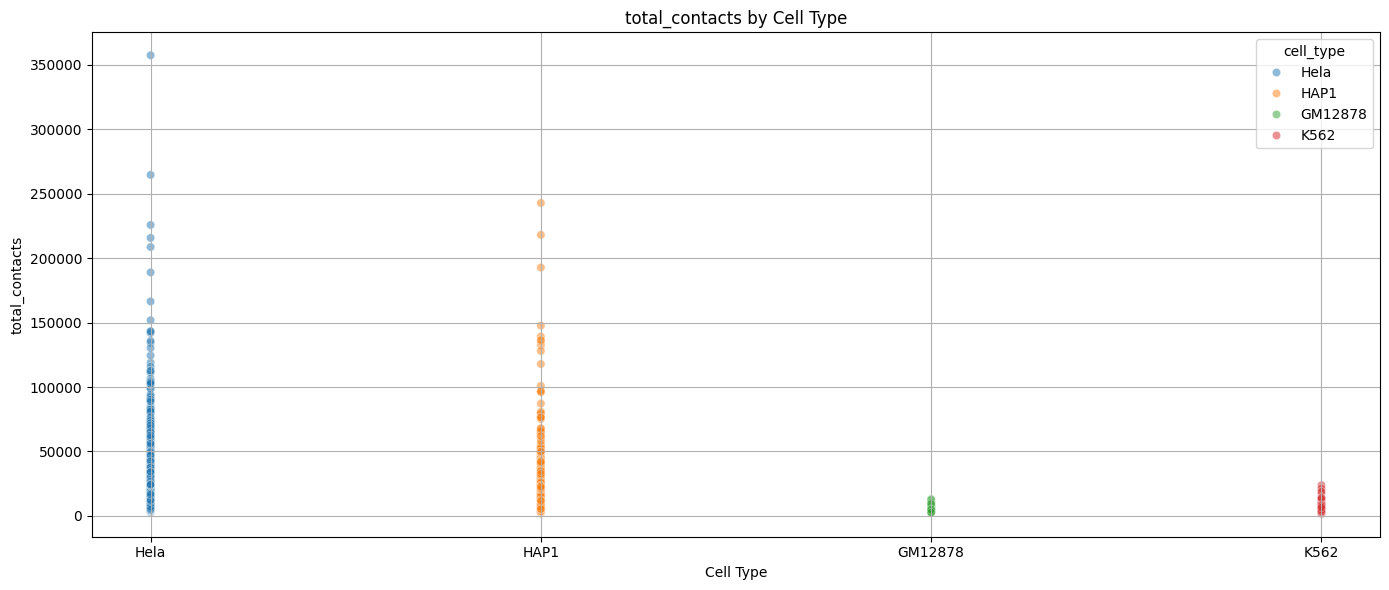

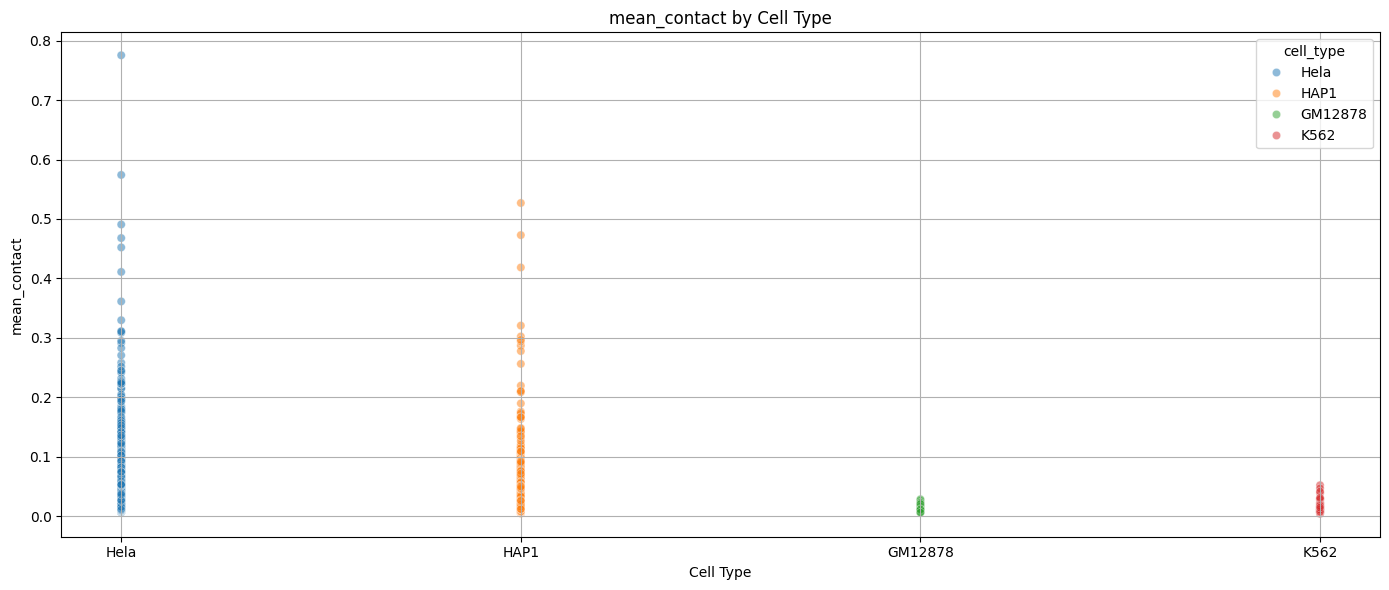

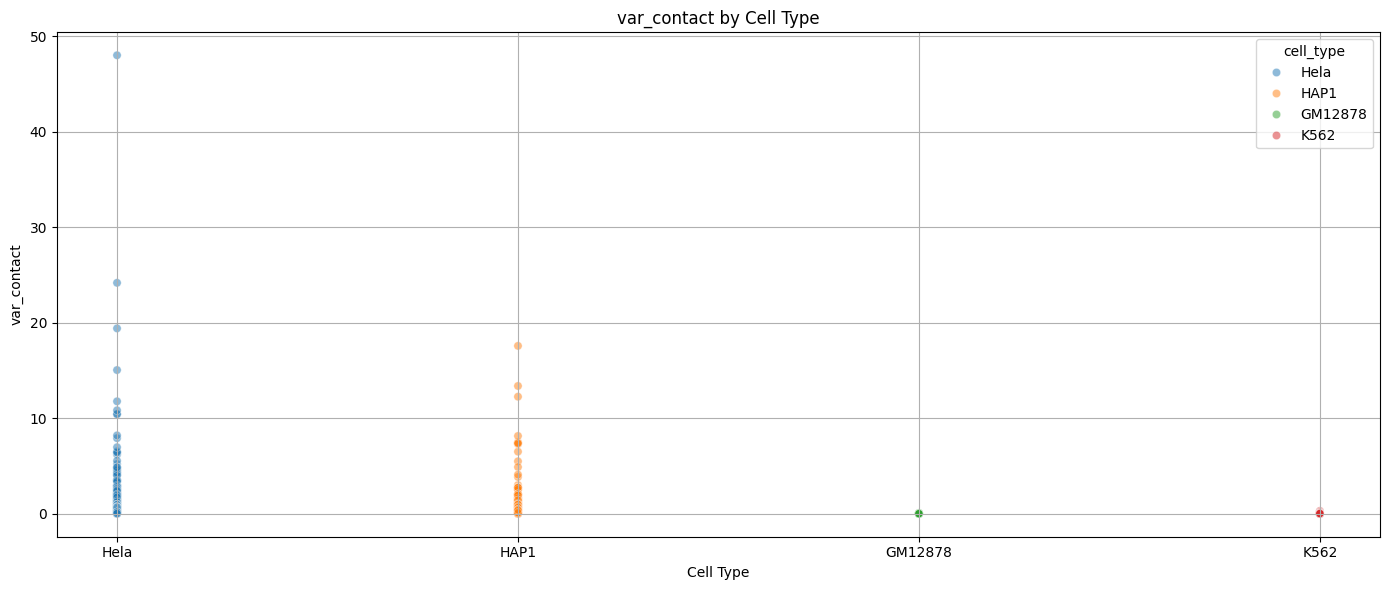

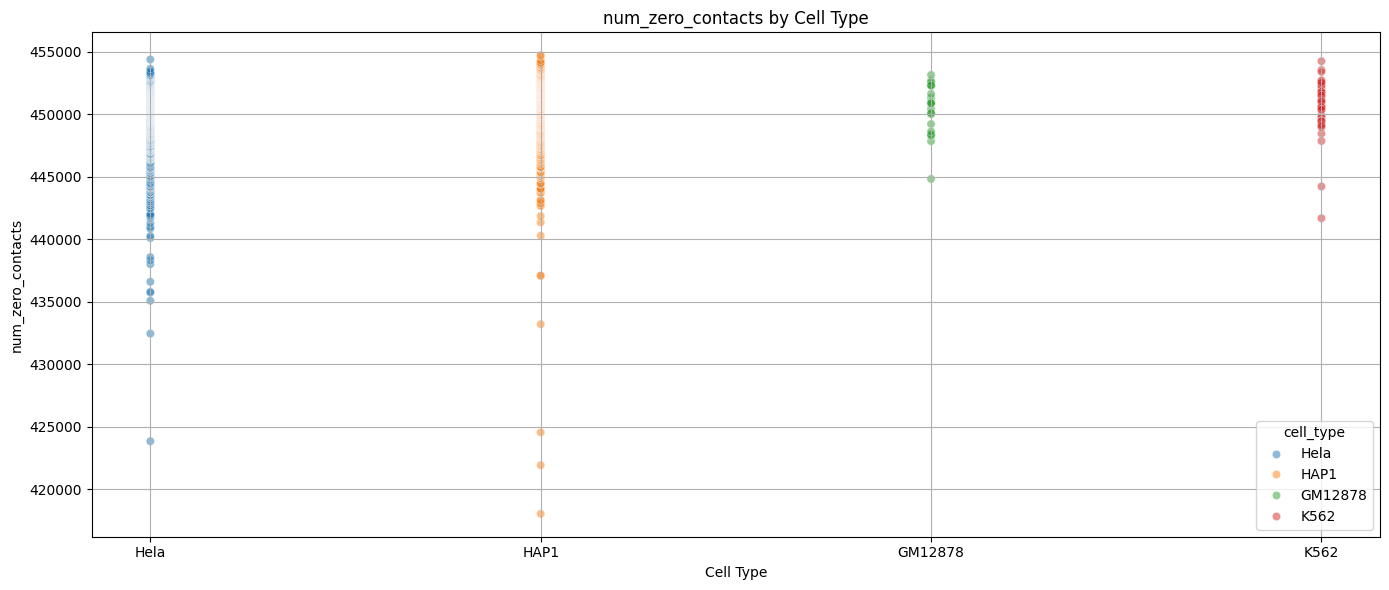

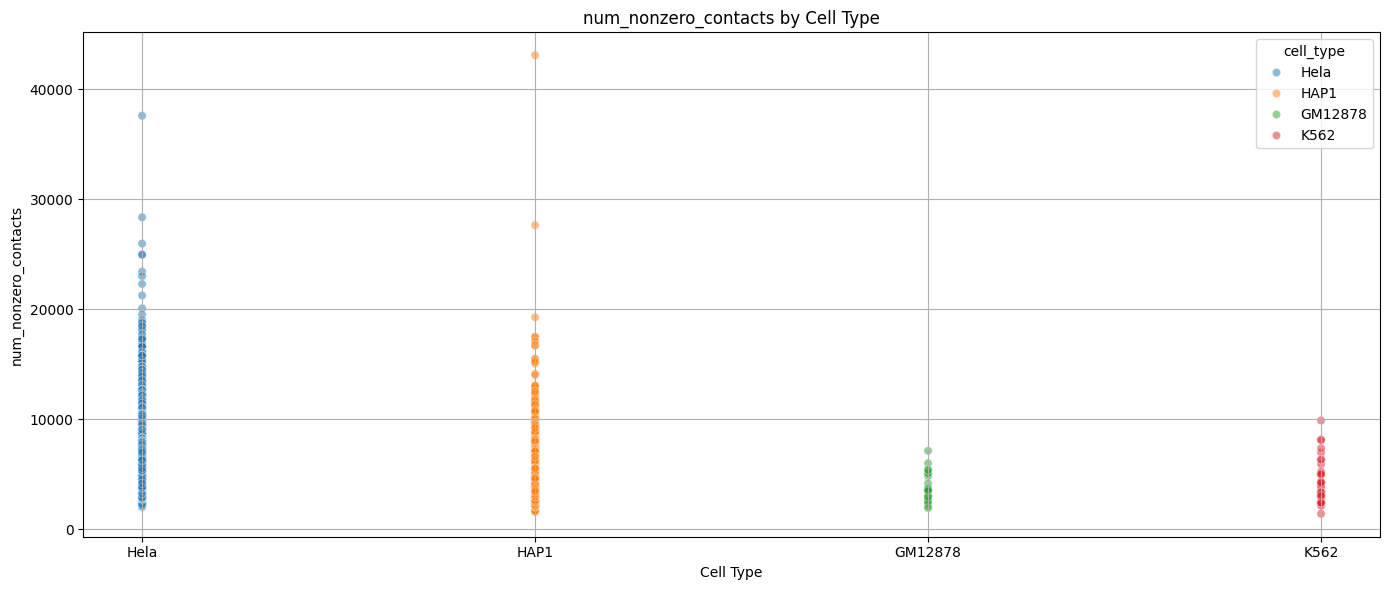

In [321]:
cell_type_counts = test_df["cell_type"].value_counts()
print(cell_type_counts)
for col in test_df.columns[1:6]:
    plt.figure(figsize=(14, 6))
    sns.scatterplot(data=test_df, x="cell_type", y=col, hue="cell_type", alpha=0.5)
    plt.title(f"{col} by Cell Type")
    plt.ylabel(f"{col}")
    plt.xlabel("Cell Type")
    plt.grid(True)
    plt.tight_layout()
    plt.show()

In [324]:
# Melt wide to long
long_df = test_df.melt(
    id_vars=["cell_type"],
    var_name="feature",
    value_name="value"
)

# Extract chromosome and statistic type
long_df[["chromosome", "stat"]] = long_df["feature"].str.extract(r"(chr\d+|chrX)_(\w+)")
long_df = long_df.dropna(subset=["chromosome", "stat"])

# Define proper chromosome order
chrom_order = ["chr1", "chr2", "chr3", "chr4", "chr5", "chr6", "chr7", "chr8", "chr9", "chr10",
               "chr11", "chr12", "chr13", "chr14" "chr15", "chr16", "chr17", "chr18", "chr19", 
               "chr20", "chr21", "chr22", "chrX"]
drop_chroms_cleaned = [c[:-1] if c.endswith('_') else c for c in drop_chroms]
chrom_order = [c for c in chrom_order if c not in drop_chroms_cleaned]

# Apply categorical dtype with correct order
long_df["chromosome"] = pd.Categorical(long_df["chromosome"], categories=chrom_order, ordered=True)

/var/folders/zz/fn6m71xn7kx55y0nwsb0gxsh0000gn/T/ipykernel_51441/524709743.py:8: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  avg_df = stat_df.groupby(["chromosome", "cell_type"])["value"].mean().reset_index()


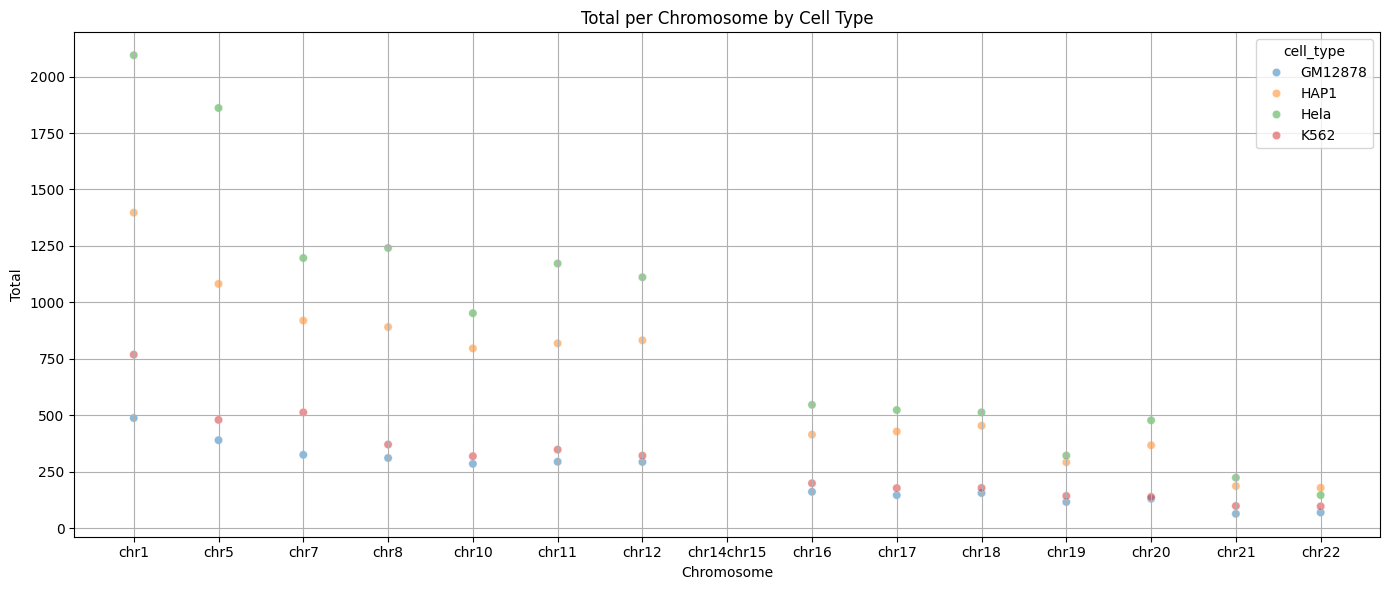

/var/folders/zz/fn6m71xn7kx55y0nwsb0gxsh0000gn/T/ipykernel_51441/524709743.py:8: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  avg_df = stat_df.groupby(["chromosome", "cell_type"])["value"].mean().reset_index()


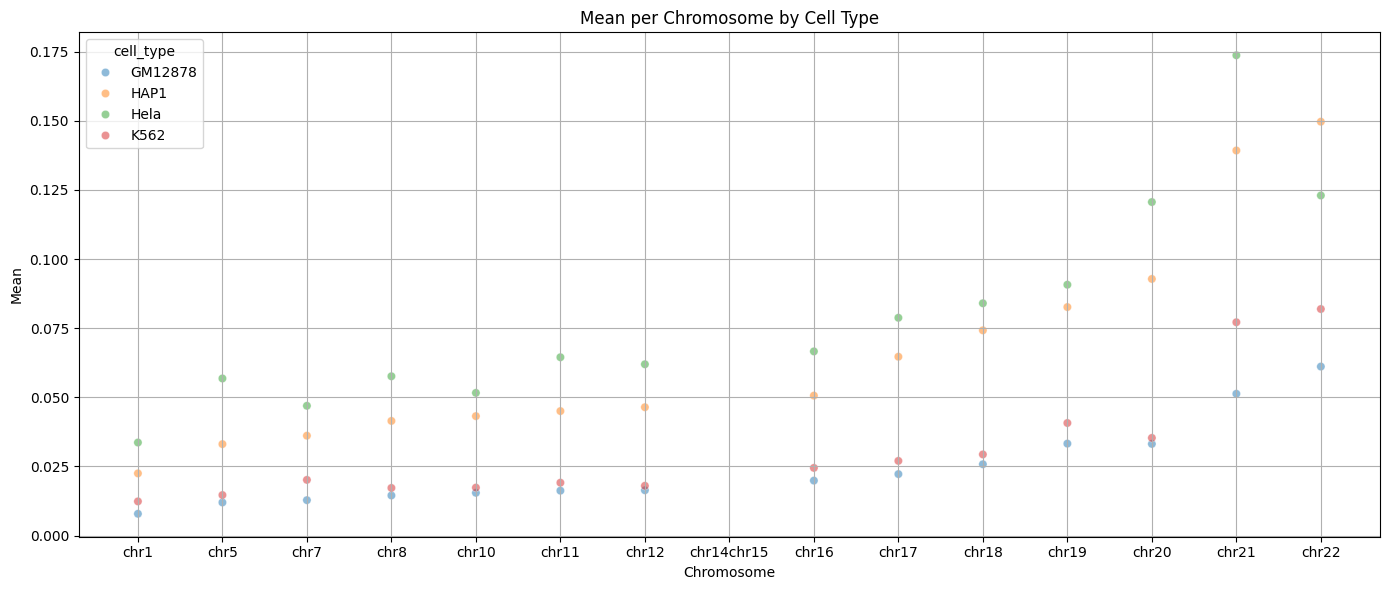

/var/folders/zz/fn6m71xn7kx55y0nwsb0gxsh0000gn/T/ipykernel_51441/524709743.py:8: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  avg_df = stat_df.groupby(["chromosome", "cell_type"])["value"].mean().reset_index()


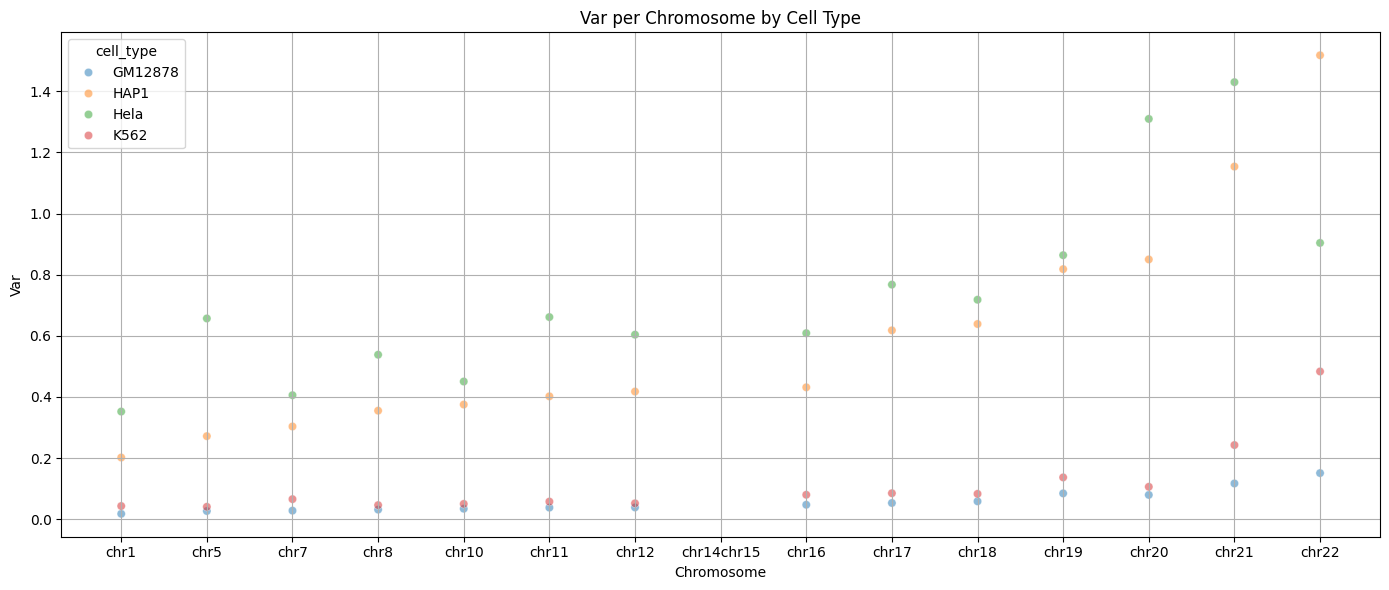

/var/folders/zz/fn6m71xn7kx55y0nwsb0gxsh0000gn/T/ipykernel_51441/524709743.py:8: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  avg_df = stat_df.groupby(["chromosome", "cell_type"])["value"].mean().reset_index()


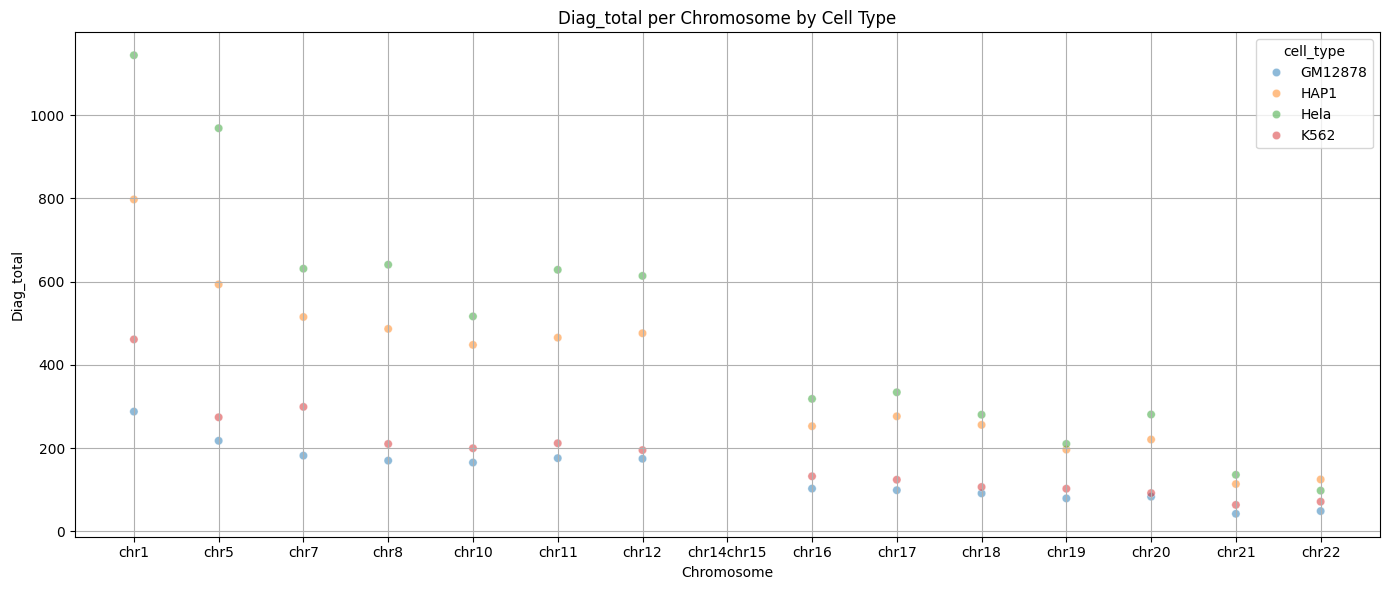

/var/folders/zz/fn6m71xn7kx55y0nwsb0gxsh0000gn/T/ipykernel_51441/524709743.py:8: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  avg_df = stat_df.groupby(["chromosome", "cell_type"])["value"].mean().reset_index()


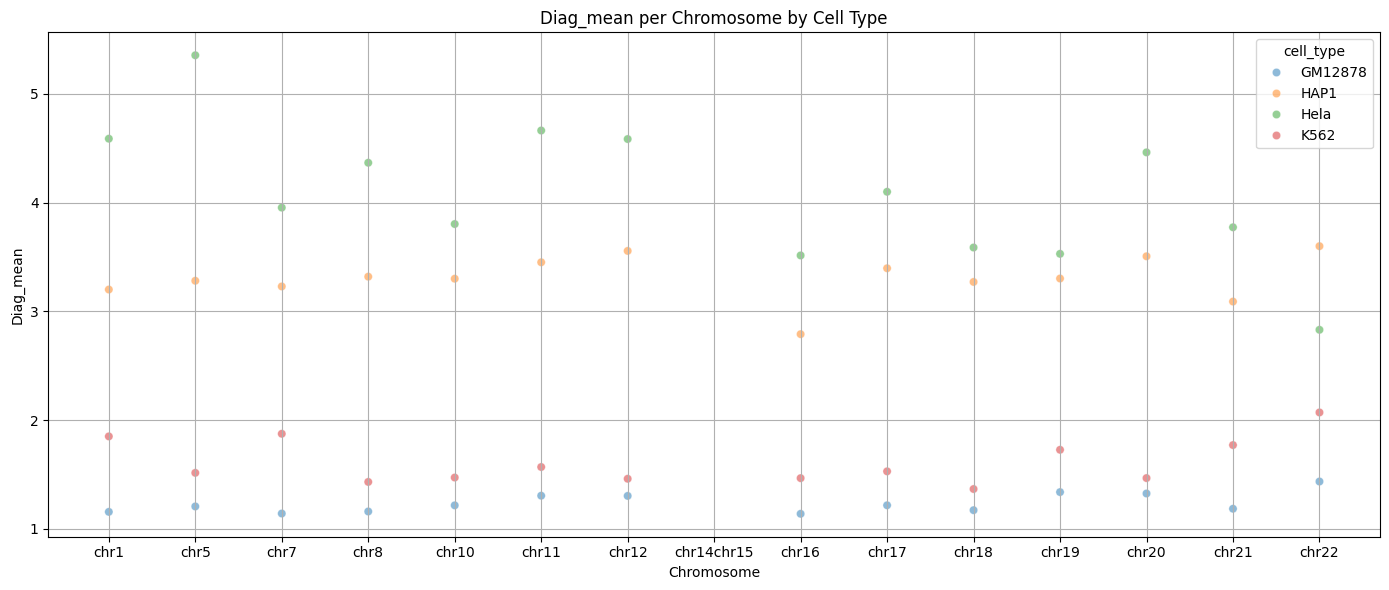

/var/folders/zz/fn6m71xn7kx55y0nwsb0gxsh0000gn/T/ipykernel_51441/524709743.py:8: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  avg_df = stat_df.groupby(["chromosome", "cell_type"])["value"].mean().reset_index()


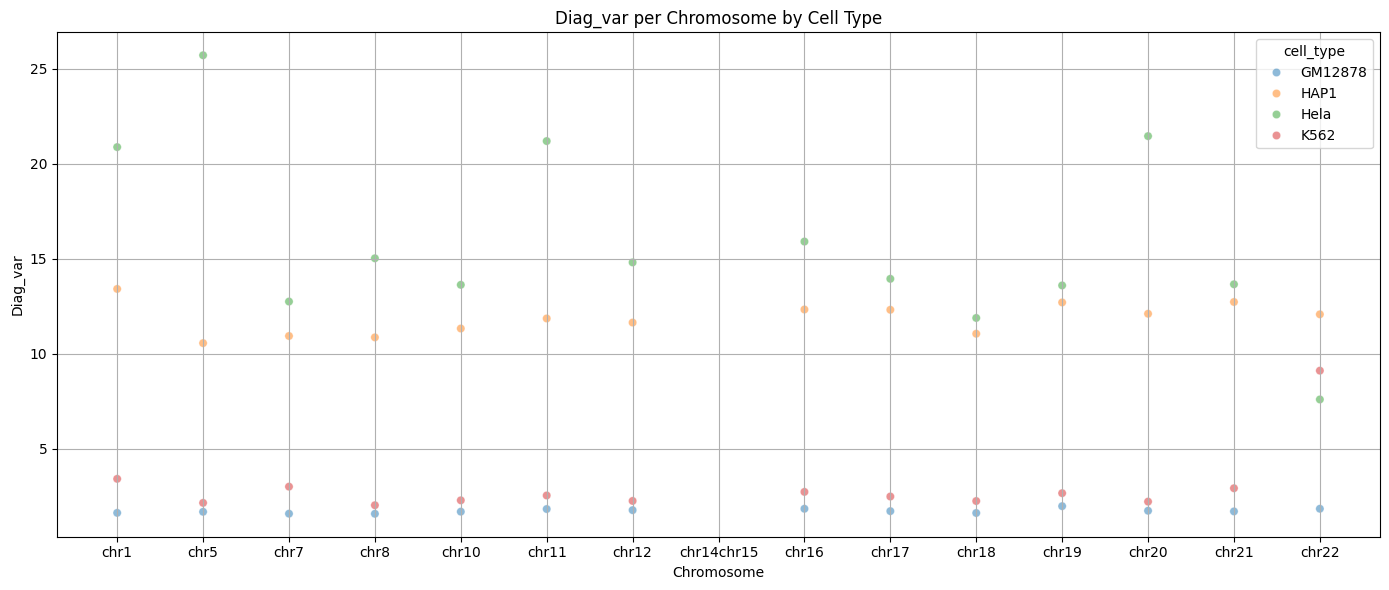

/var/folders/zz/fn6m71xn7kx55y0nwsb0gxsh0000gn/T/ipykernel_51441/524709743.py:8: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  avg_df = stat_df.groupby(["chromosome", "cell_type"])["value"].mean().reset_index()


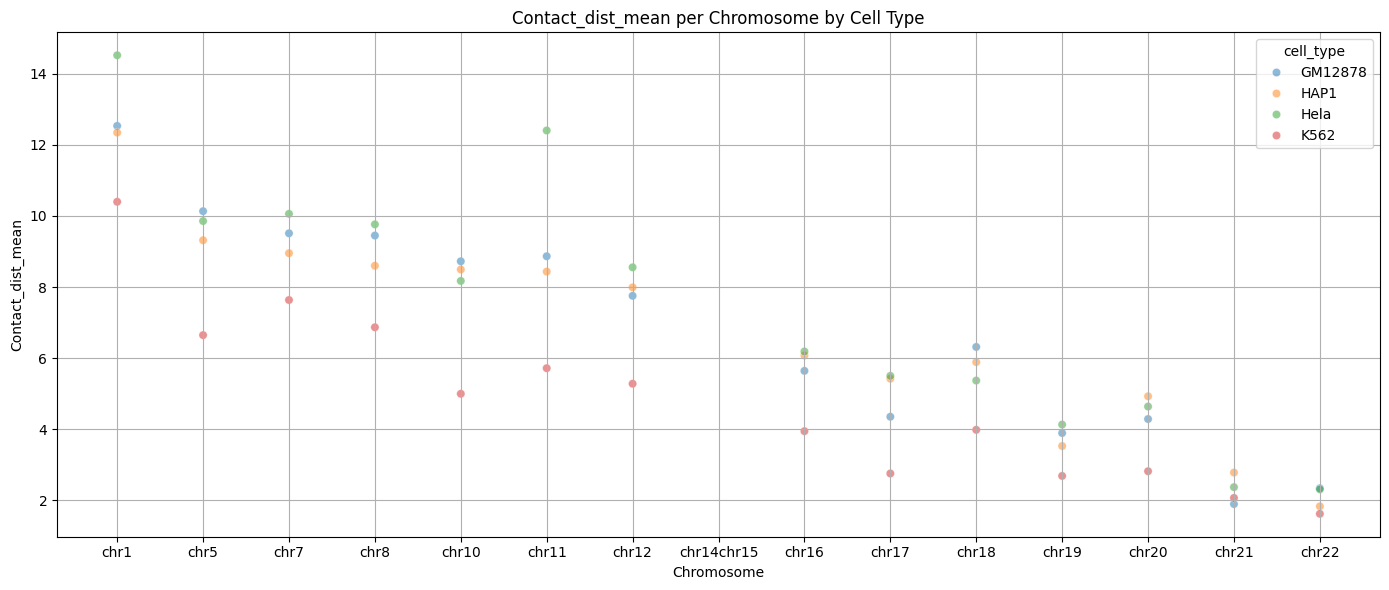

/var/folders/zz/fn6m71xn7kx55y0nwsb0gxsh0000gn/T/ipykernel_51441/524709743.py:8: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  avg_df = stat_df.groupby(["chromosome", "cell_type"])["value"].mean().reset_index()


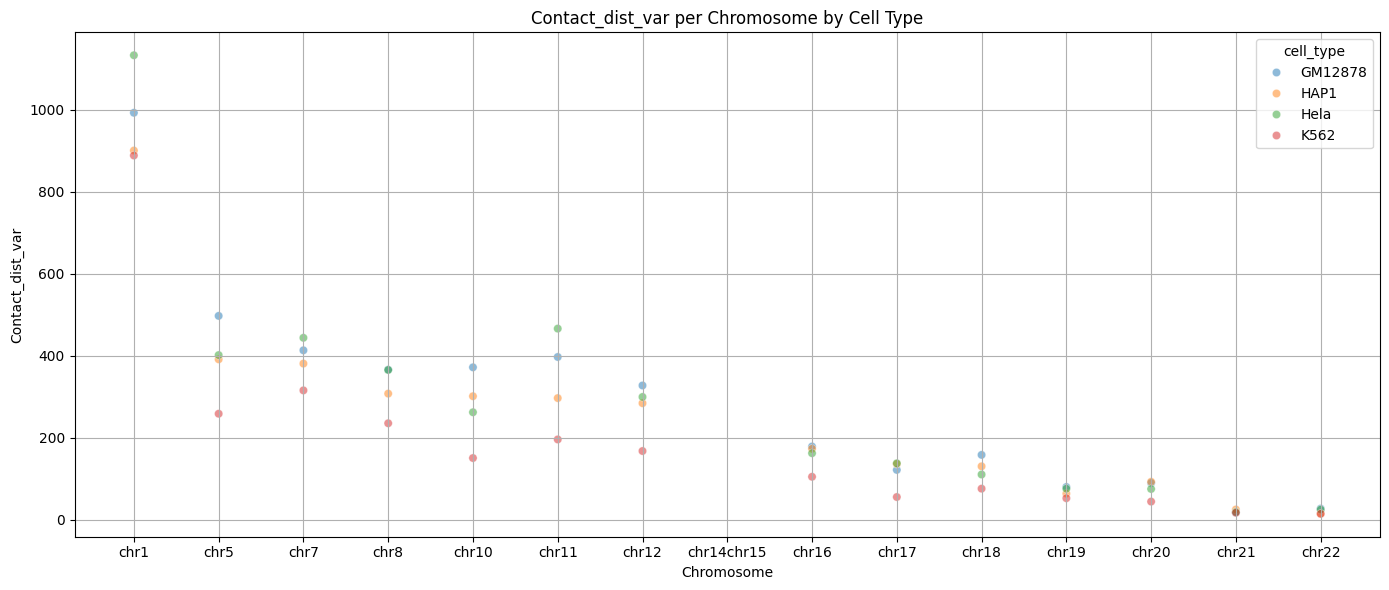

In [325]:
# Get unique statistics (e.g., mean, total, variance)
unique_stats = long_df["stat"].unique()

for stat in unique_stats:
    stat_df = long_df[long_df["stat"] == stat]

    # Group by chromosome and cell type for bar heights
    avg_df = stat_df.groupby(["chromosome", "cell_type"])["value"].mean().reset_index()

    # Barplot
    plt.figure(figsize=(14, 6))
    sns.scatterplot(data=avg_df, x="chromosome", y="value", hue="cell_type", alpha=0.5)
    plt.title(f"{stat.capitalize()} per Chromosome by Cell Type")
    plt.ylabel(f"{stat.capitalize()}")
    plt.xlabel("Chromosome")
    plt.grid(True)
    plt.tight_layout()
    plt.show()


In [214]:
# drop non-numerical columns
features_df = test_df.drop(columns=["cell_type", "cell_id"], errors="ignore")
true_labels = test_df["cell_type"].values

# standardize data
scaler = StandardScaler()
X_scaled = scaler.fit_transform(features_df)

# find PC1 & PC2 of scaled data
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

# find UMAP1 & UMAP2
umap_model = umap.UMAP(n_components=2, random_state=42)
X_umap = umap_model.fit_transform(X_scaled)

# find tSNE1 & tSNE2
tsne = TSNE(n_components=2, random_state=42, perplexity=30, learning_rate=200)
X_tsne = tsne.fit_transform(X_scaled)

/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


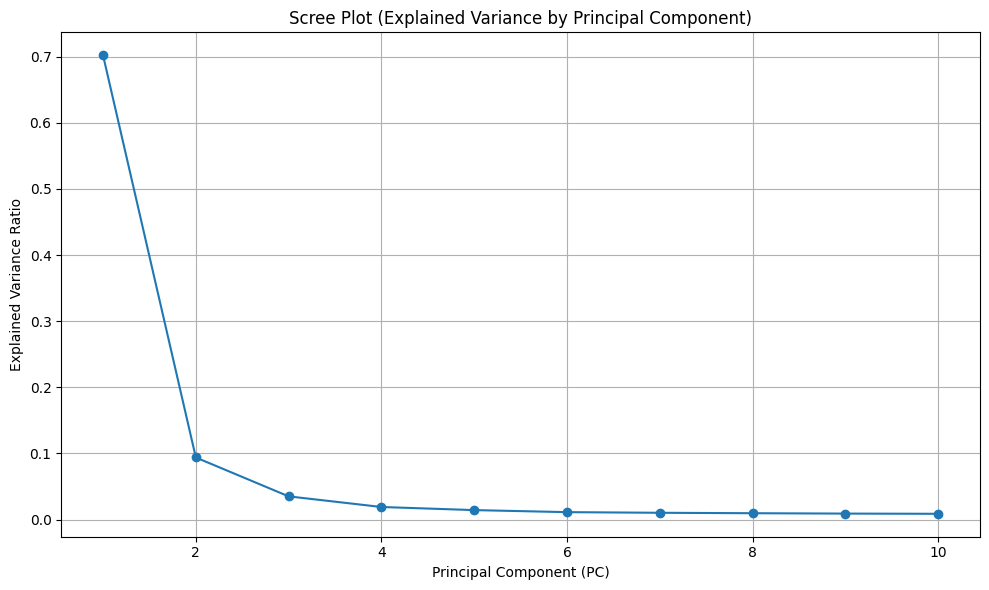

In [ ]:
pca = PCA(n_components=min(X_scaled.shape[1], 10))
X_pca_full = pca.fit_transform(X_scaled)

# Scree plot
plt.figure(figsize=(10, 6))
plt.plot(np.arange(1, len(pca.explained_variance_ratio_) + 1), pca.explained_variance_ratio_, marker='o')
plt.title('Scree Plot (Explained Variance by Principal Component)')
plt.xlabel('Principal Component (PC)')
plt.ylabel('Explained Variance Ratio')
plt.grid(True)
plt.tight_layout()
plt.show()

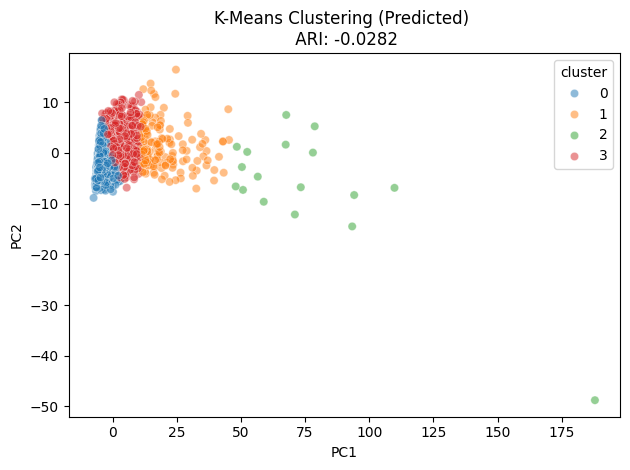

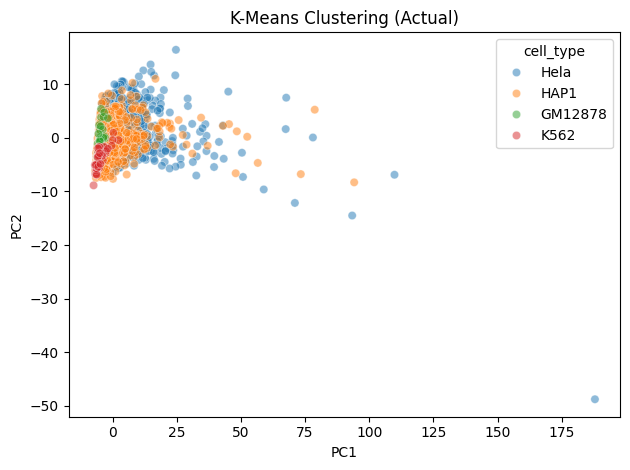

In [210]:
# fit KMean to PCA
kmeans = KMeans(n_clusters=4, random_state=42)
cluster_labels = kmeans.fit_predict(X_pca)
ari = adjusted_rand_score(true_labels, cluster_labels)

cluster_df = pd.DataFrame(X_pca, columns=["PC1", "PC2"])
cluster_df["cluster"] = cluster_labels
cluster_df["cell_type"] = test_df["cell_type"].values  # actual labels


# Step 4: Plot with predicted labels
sns.scatterplot(data=cluster_df, x="PC1", y="PC2", hue="cluster", palette="tab10", alpha=0.5)
plt.title(f"K-Means Clustering (Predicted) \n ARI: {round(ari, 4)}")
plt.tight_layout()
plt.show()

# Step 5: Plot actual labels for comparison
sns.scatterplot(data=cluster_df, x="PC1", y="PC2", hue="cell_type", palette="tab10", alpha=0.5)
plt.title("K-Means Clustering (Actual)")
plt.tight_layout()
plt.show()

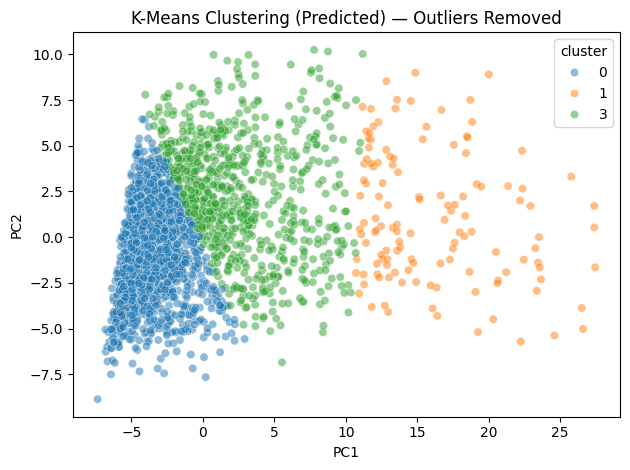

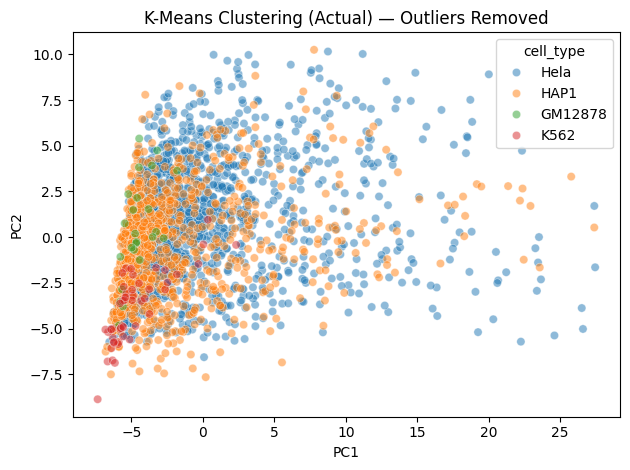

In [211]:
# Calculate z-scores for each PC column
z_scores = np.abs((cluster_df[["PC1", "PC2"]] - cluster_df[["PC1", "PC2"]].mean()) / cluster_df[["PC1", "PC2"]].std())

# Threshold for being considered an outlier (e.g., z > 3)
non_outliers = (z_scores < 3).all(axis=1)

# Filter the DataFrame
filtered_df = cluster_df[non_outliers]

sns.scatterplot(data=filtered_df, x="PC1", y="PC2", hue="cluster", palette="tab10", alpha=0.5)
plt.title("K-Means Clustering (Predicted) — Outliers Removed")
plt.tight_layout()
plt.show()

sns.scatterplot(data=filtered_df, x="PC1", y="PC2", hue="cell_type", palette="tab10", alpha=0.5)
plt.title("K-Means Clustering (Actual) — Outliers Removed")
plt.tight_layout()
plt.show()


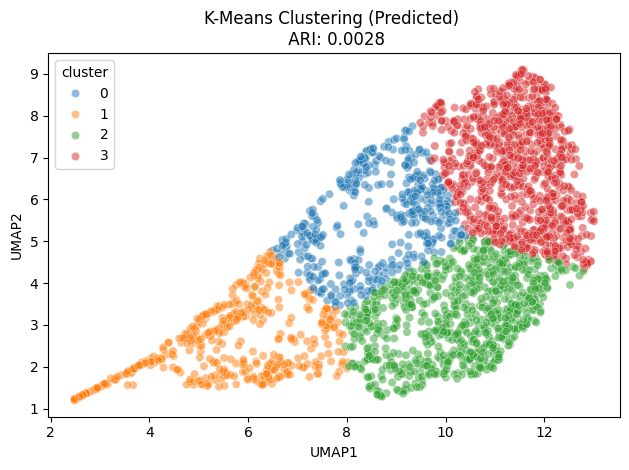

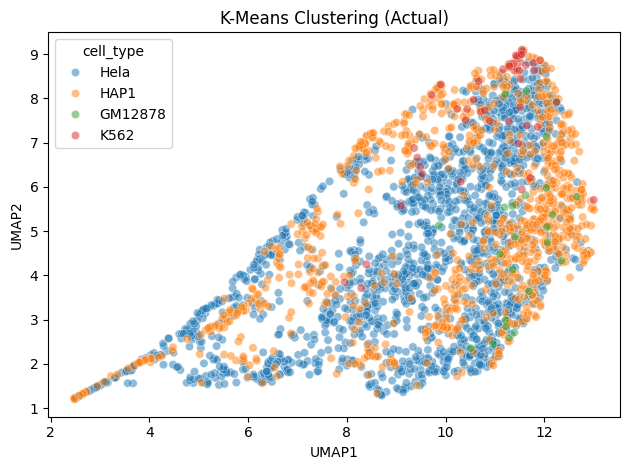

In [216]:
kmeans = KMeans(n_clusters=4, random_state=42)
cluster_labels = kmeans.fit_predict(X_umap)
ari = adjusted_rand_score(true_labels, cluster_labels)

cluster_df = pd.DataFrame(X_umap[:, :2], columns=["UMAP1", "UMAP2"])
cluster_df["cluster"] = cluster_labels
cluster_df["cell_type"] = test_df["cell_type"].values

sns.scatterplot(data=cluster_df, x="UMAP1", y="UMAP2", hue="cluster", palette="tab10", alpha=0.5)
plt.title(f"K-Means Clustering (Predicted) \n ARI: {round(ari, 4)}")
plt.tight_layout()
plt.show()

sns.scatterplot(data=cluster_df, x="UMAP1", y="UMAP2", hue="cell_type", palette="tab10", alpha=0.5)
plt.title("K-Means Clustering (Actual)")
plt.tight_layout()
plt.show()

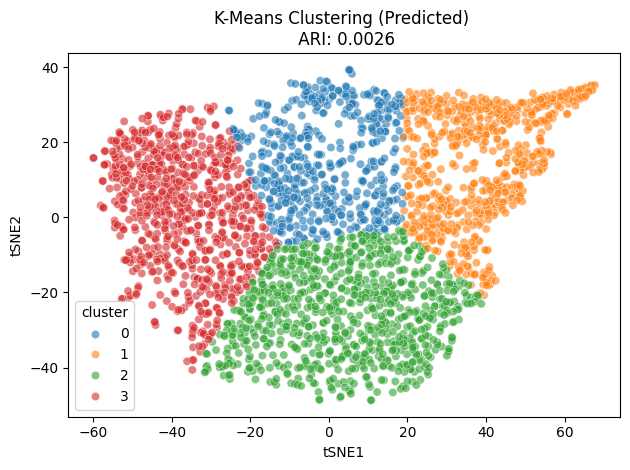

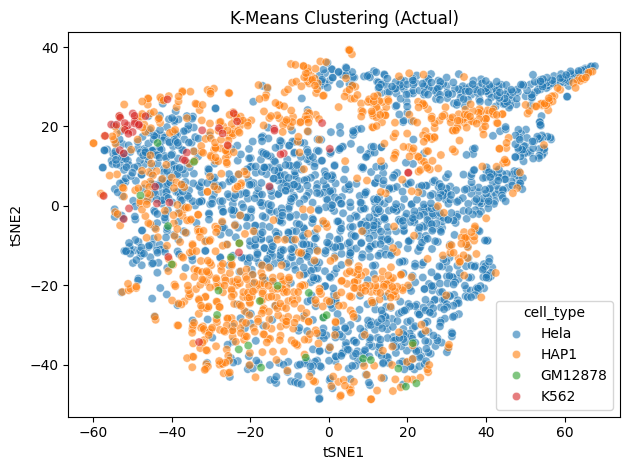

In [217]:
kmeans = KMeans(n_clusters=4, random_state=42)
cluster_labels = kmeans.fit_predict(X_tsne)
ari = adjusted_rand_score(true_labels, cluster_labels)

cluster_df = pd.DataFrame(X_tsne, columns=["tSNE1", "tSNE2"])
cluster_df["cluster"] = cluster_labels
cluster_df["cell_type"] = test_df["cell_type"].values

sns.scatterplot(data=cluster_df, x="tSNE1", y="tSNE2", hue="cluster", palette="tab10", alpha=0.6)
plt.title(f"K-Means Clustering (Predicted) \n ARI: {round(ari, 4)}")
plt.tight_layout()
plt.show()

# Ground truth
sns.scatterplot(data=cluster_df, x="tSNE1", y="tSNE2", hue="cell_type", palette="tab10", alpha=0.6)
plt.title("K-Means Clustering (Actual)")
plt.tight_layout()
plt.show()

In [110]:
def extract_upper_triangle_features(matrix: pd.DataFrame) -> np.ndarray:
    """
    Extracts and concatenates the upper triangle (excluding diagonal)
    from all diagonal contact matrices in a block matrix.
    
    Returns a 1D feature vector.
    """
    features = []
    for chr in matrix.index:
        block = matrix.at[chr, chr]
        if isinstance(block, pd.DataFrame):
            values = block.values
            triu_indices = np.triu_indices_from(values, k=1)  # exclude diagonal
            upper_triangle = values[triu_indices]
            features.append(upper_triangle)
    return np.concatenate(features)

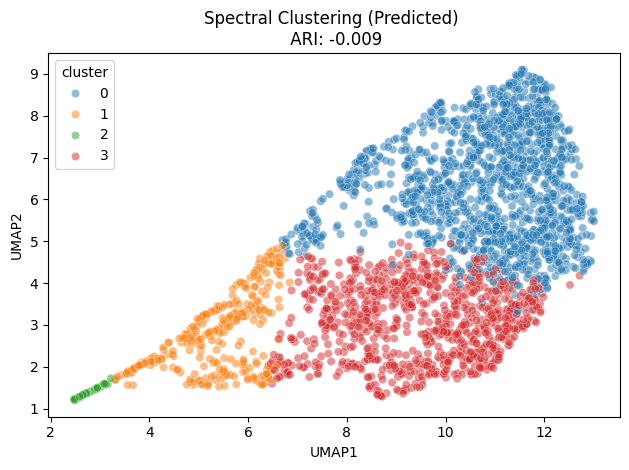

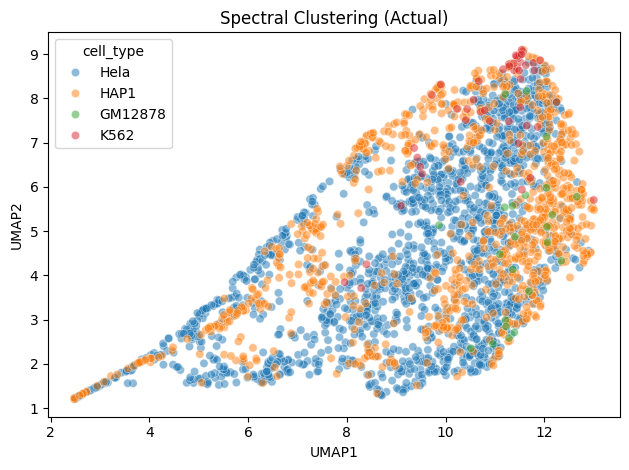

In [ ]:
spectral = SpectralClustering(n_clusters=4, affinity='nearest_neighbors', 
                              n_neighbors=10, assign_labels='kmeans', 
                              random_state=42)
cluster_labels = spectral.fit_predict(X_scaled)
ari = adjusted_rand_score(true_labels, cluster_labels)

cluster_df = pd.DataFrame(X_umap, columns=["UMAP1", "UMAP2"], index=test_df.index)
cluster_df["cluster"] = cluster_labels
cluster_df["cell_type"] = test_df["cell_type"]

sns.scatterplot(data=cluster_df, x="UMAP1", y="UMAP2", hue="cluster", palette="tab10", alpha=0.5)
plt.title(f"Spectral Clustering (Predicted) \n ARI: {round(ari, 4)}")
plt.tight_layout()
plt.show()

sns.scatterplot(data=cluster_df, x="UMAP1", y="UMAP2", hue="cell_type", palette="tab10", alpha=0.5)
plt.title("Spectral Clustering (Actual)")
plt.tight_layout()
plt.show()

/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


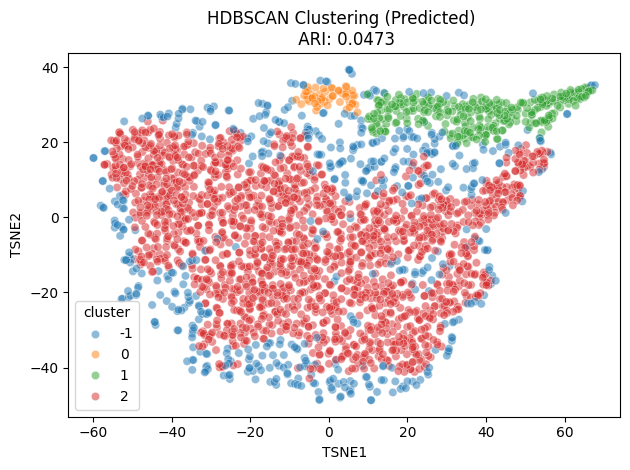

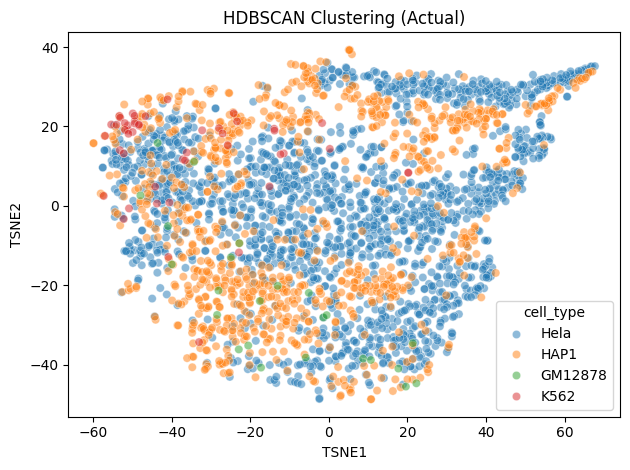

In [326]:
db = hdbscan.HDBSCAN(min_cluster_size=10, min_samples=18) #, cluster_selection_epsilon=2)
cluster_labels = db.fit_predict(X_tsne)
ari = adjusted_rand_score(test_df["cell_type"], cluster_labels)

cluster_df = pd.DataFrame(X_tsne, columns=["TSNE1", "TSNE2"], index=test_df.index)
cluster_df["cluster"] = cluster_labels
cluster_df["cell_type"] = test_df["cell_type"]

sns.scatterplot(data=cluster_df, x="TSNE1", y="TSNE2", hue="cluster", palette="tab10", alpha=0.5)
plt.title(f"HDBSCAN Clustering (Predicted) \n ARI: {round(ari, 4)}")
plt.tight_layout()
plt.show()

sns.scatterplot(data=cluster_df, x="TSNE1", y="TSNE2", hue="cell_type", palette="tab10", alpha=0.5)
plt.title("HDBSCAN Clustering (Actual)")
plt.tight_layout()
plt.show()